# 	Online approach to near time-optimal task-space trajectory planning

Comparison of Robot's movement capacity aware real-time trajectory planning in Cartesian Space with TOPPRA 

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
import time

import pinocchio as pin
from example_robot_data import load
from planning_utils import *

import meshcat
from pinocchio.visualize import MeshcatVisualizer
from meshcat_shapes import *


/home/gospar/miniconda3/envs/toppra_cart/lib/python3.12/site-packages/meshcat/servers/zmqserver.py:18: DeprecationWarning: zmq.eventloop.ioloop is deprecated in pyzmq 17. pyzmq now works with default tornado and asyncio eventloops.
  import zmq.eventloop.ioloop
/home/gospar/miniconda3/envs/toppra_cart/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Visualise the robot

In [2]:
from pynocchio import RobotWrapper

panda_pin = load('panda')
panda_pin.data = panda_pin.model.createData()

viewer = meshcat.Visualizer()

panda_tip_pin = "panda_hand_tcp"

panda_pyn = RobotWrapper(robot_wrapper=panda_pin,  tip=panda_tip_pin, open_viewer=False, start_visualisation=True, viewer=viewer, fix_joints= [panda_pin.model.getJointId("panda_finger_joint1"),panda_pin.model.getJointId("panda_finger_joint2")])
viz = panda_pyn.viz

# Load the robot in the viewer.
viz.display_collisions = False
display(viz, panda_pyn, panda_tip_pin, "end_effector_target", panda_pyn.robot.q0)
# comment this line to have the meshcat open in another vindow
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


/home/gospar/miniconda3/envs/toppra_cart/lib/python3.12/site-packages/pinocchio/visualize/meshcat_visualizer.py:129: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if img_lib_element:


## Defining the Cartesian space path

In [3]:
# trajectory length
traj_length = 0.8
#number of waypoints in joint space
n_waypoints  = int(traj_length/0.05)

q0 = (panda_pyn.model.upperPositionLimit + panda_pyn.model.lowerPositionLimit)/2

X_init, X_final, q_line = find_random_poses_with_distance_pinocchio(robot=panda_pyn, distance=traj_length, q0=q0, verify_line = True, n_waypoints= n_waypoints, angle=np.pi/2)
print('initial point:\t', X_init)
print('final point:\t',X_final)

d = np.linalg.norm(X_final.translation-X_init.translation)

print('waypoints num:\t',n_waypoints)
print('traj length:\t',traj_length)

display(viz, panda_pyn, panda_tip_pin, "end_effector_target",  panda_pyn.ik(X_init,qlim=True, verbose=False))
display_frame(viz, "end_erffector_start",  X_init.np)
display_frame(viz, "end_erffector_end",  X_final.np)

searching
not attainable final
not attainable final
verify straitgh line
16
initial point:	   R =
  0.31439 -0.161998 -0.935369
0.0231953 -0.983726   0.17817
 -0.94901 -0.077711 -0.305517
  p = 0.249791 0.241411 0.476675

final point:	   R =
  0.31439 -0.161998 -0.935369
0.0231953 -0.983726   0.17817
 -0.94901 -0.077711 -0.305517
  p = 0.0877812 -0.454353  0.116585

waypoints num:	 16
traj length:	 0.8


### Play the trajectory

In [4]:
viz.viewer.jupyter_cell()

In [5]:
for q_l in q_line:
    display(viz, panda_pyn, panda_tip_pin, "end_effector_target",  q_l)
    time.sleep(0.2)

## Defining the robot's movement capacity limits 

In [6]:
# limits
# joint space
q_min, q_max  = panda_pyn.model.lowerPositionLimit, panda_pyn.model.upperPositionLimit
dq_max = panda_pyn.model.velocityLimit
dq_min = -dq_max
ddq_max = np.array([15,7.5,10,12.5,15,20,20])
ddq_min = -ddq_max
dddq_max = np.array([7500, 3750, 5000,6250,7500,10000,10000])
dddq_min = -dddq_max
t_max = np.array([87, 87, 87, 87, 20, 20, 20])
t_min = -t_max

# cartesian space
dddx_max = np.array([6500.0,6500.0,6500.0])
dddx_min = -dddx_max
ddx_max = np.array([13.0,13,13])
ddx_min = -ddx_max
dx_max = np.array([1.7,1.7,1.7])
dx_min = -dx_max

limits = {'q_min':q_min, 'q_max':q_max, 'dq_max': dq_max, 'ddq_max':ddq_max, 'dddq_max':dddq_max, 't_max':t_max, 'dx_max':dx_max, 'ddx_max':ddx_max, 'dddx_max':dddx_max }

## Defining the capacity scaling factor

In [7]:
#capacity scaling
scale  = 0.5
print('capacity scale:\t',scale)

capacity scale:	 0.5


## Calculate the trajecoty using the proposed method

In [8]:
options = {
            'Kp': 600, 
            'Kd':150, 
            'Ki':000.0,
            'Tf':0.01,             
            # 'jerk_scale': 0.05,
            'uptate_current_position': True,
            'clamp_velocity':True, 
            'clamp_min_accel':True,
            'scaled_qp_limits':True, # True to use the same limits in QP and the TOPCA
            'override_acceleration':True, 
            'scale_limits':True,
            'calculate_limits':True,
            'downsampling_ratio': 1,
            'use_manip_grad': False,
            'manip_grad_w': 5000.0,
            'dt':0.001,
            'qp_form': 'acceleration' # 'velocity' or 'acceleration'
            #'qp_form': 'velocity' # 'velocity' or 'acceleration'
          }
data = compute_capacity_aware_trajectory(X_init, X_final, robot=None, robot_pyn=panda_pyn,  lims=limits, scale=scale, options=options, q0 = (q_min + q_max)/2) #q0)

t	0
Calculation duration: 5.534943580627441 [s]
Trajectory duration: 1.6680 [s]


## Calculate the trajecoty using TOPPRA

In [9]:
# calculate the joint space path and find the time-optimal trajecoty using TOPPRA
ts_sample, qs_sample, qds_sample, qdds_sample = caclulate_toppra_trajectory(X_init, X_final, robot_pyn=panda_pyn, q0=q0, d_waypoint=0.05, lims=limits, scale = scale)

# simulate the calculated trajectory by toppra
data_top = simulate_toppra(X_init, X_final, ts_sample, qs_sample,qds_sample,qdds_sample, q0=q0, robot_pyn=panda_pyn, lims=limits, scale = scale, options=options)

simulating trajectory
TOPPRA trajecotry simulation time 2.013817310333252
Trajectory duration: 1.7460 [s]


In [10]:
print("TOPPRA trajectory duration:{}".format(ts_sample[-1]))
print("ours trajectory duration:{}".format(data.t_ruckig[-1]))

TOPPRA trajectory duration:1.746
ours trajectory duration:1.668


## Visualisation of the obtained trajectories 


Visualising the time evalution of trajecotyr variables
- $s$: scalar position on the trajectory
- $\dot{s}$: scalar velocity on the trajectory
- $\ddot{s}$: scalar acceleration on the trajectory
- $\dddot{s}$: scalar jerk on the trajectory

Additionally for both our approach and TOPPRA the state dependent robot's movement capacity is calculated and visualised in black dashed lines

/home/gospar/miniconda3/envs/toppra_cart/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


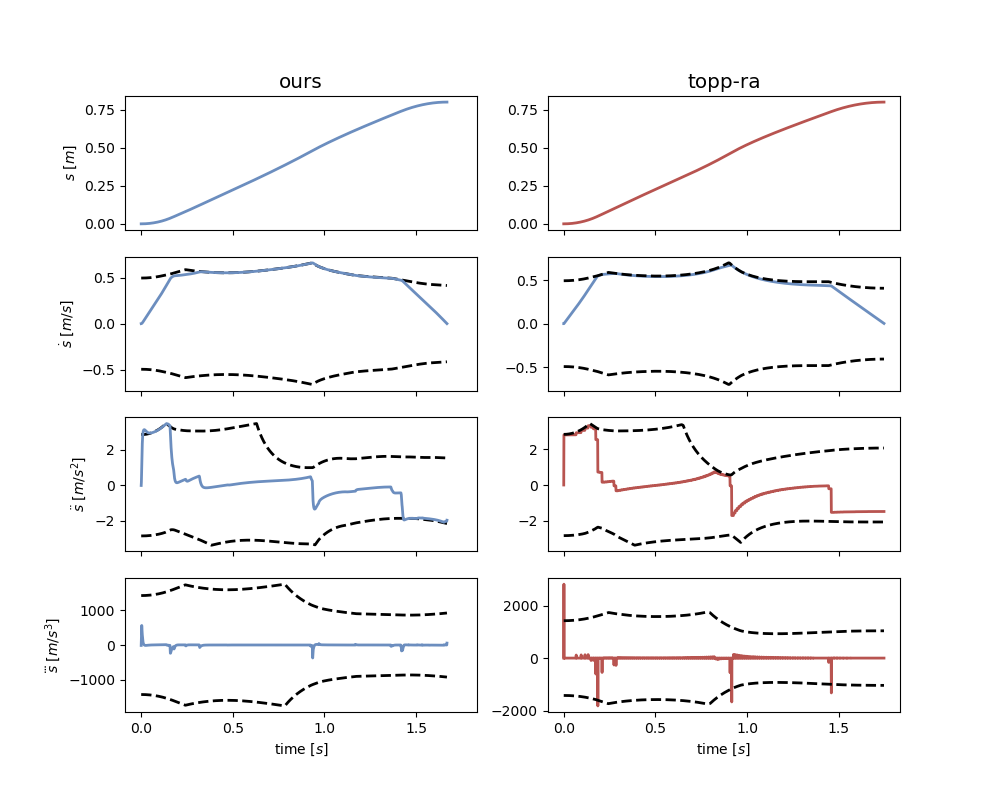

/tmp/ipykernel_183931/3426285098.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [11]:
plt.rcParams['axes.facecolor'] = 'white'
fig, axs = plt.subplots(4, 2, sharex=True, figsize=[10, 8])

linewidth = 2
fontsize = 12
plt.rcParams.update({'font.size': fontsize,'xtick.color':'black', 'ytick.color':'black'})
axs[0,0].plot(data.t_ruckig[1:],data.x_q_list[1:],'#6C8EBF', linewidth=linewidth)
axs[0,1].plot(data_top.t_toppra, data_top.x_top,'#B85450', linewidth=linewidth)
axs[1,0].plot(data.t_ruckig[1:],data.dx_max_list[1:],'k--', linewidth=linewidth)
axs[1,0].plot(data.t_ruckig[1:],data.dx_min_list[1:],'k--', linewidth=linewidth)
axs[1,0].plot(data.t_ruckig[1:],data.dx_q_list[1:],'#6C8EBF', linewidth=linewidth)
axs[1,1].plot(data_top.t_toppra, data_top.dx_top,'#6C8EBF', linewidth=linewidth)
axs[1,1].plot(data_top.t_toppra,data_top.ds_max_list,'k--', linewidth=linewidth)
axs[1,1].plot(data_top.t_toppra,data_top.ds_min_list,'k--', linewidth=linewidth)
axs[2,0].plot(data.t_ruckig[1:],data.ddx_max_list[1:],'k--', linewidth=linewidth)
axs[2,0].plot(data.t_ruckig[1:],data.ddx_min_list[1:],'k--', linewidth=linewidth)
axs[2,0].plot(data.t_ruckig[1:],data.ddx_q_list[1:],'#6C8EBF', linewidth=linewidth)
axs[2,1].plot(data_top.t_toppra, data_top.ddx_top,'#B85450', linewidth=linewidth)
axs[2,1].plot(data_top.t_toppra,data_top.dds_max_list,'k--', linewidth=linewidth)
axs[2,1].plot(data_top.t_toppra,data_top.dds_min_list,'k--', linewidth=linewidth)
axs[3,0].plot(data.t_ruckig[1:],data.dddx_max_list[1:],'k--', linewidth=linewidth)
axs[3,0].plot(data.t_ruckig[1:],data.dddx_min_list[1:],'k--', linewidth=linewidth)
axs[3,0].plot(data.t_ruckig[1:],data.dddx_q_list[1:],'#6C8EBF', linewidth=linewidth)
axs[3,1].plot(data_top.t_toppra, data_top.dddx_top,'#B85450', linewidth=linewidth)
axs[3,1].plot(data_top.t_toppra,data_top.ddds_max_list,'k--', linewidth=linewidth)
axs[3,1].plot(data_top.t_toppra,data_top.ddds_min_list,'k--', linewidth=linewidth)


axs[0,0].set_title("ours")
axs[0,0].set_ylabel(r'${s}$ $[m]$',color="black")
axs[1,0].set_ylabel(r'$\dot{s}$ $[m/s]$',color="black")
axs[2,0].set_ylabel(r'$\ddot{s}$ $[m/s^2]$',color="black")
axs[3,0].set_ylabel(r'$\dddot{s}$ $[m/s^3]$',color="black")
axs[3,0].set_xlabel(r'time $[s]$',color="black")
axs[3,1].set_xlabel(r'time $[s]$',color="black")
axs[0,1].set_title("topp-ra")
plt.show()
plt.legend()

## Visualising the comparrison 

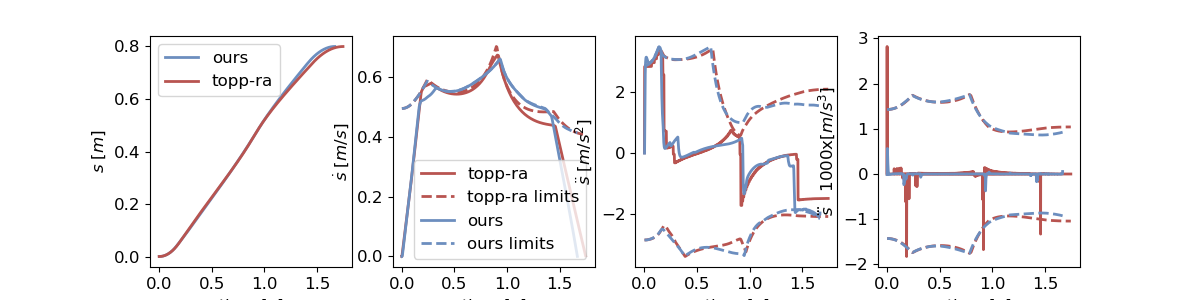

In [12]:
fig, axs = plt.subplots(1,4, sharex=True,figsize=[12, 3])
plt.rcParams['axes.facecolor'] = 'white'
linw = 2
plt.rcParams.update({'font.size': 12,'xtick.color':'black', 'ytick.color':'black'})

axs[0].plot(data.t_ruckig[1:],data.x_list[1:],linewidth=linw,color='#6C8EBF',label='ours')
axs[0].plot(ts_sample,data_top.x_top, linewidth=linw,color='#B85450',label='topp-ra')
axs[0].set_xlabel(r'time $[s]$',color="black")
axs[0].set_ylabel(r'${s}$ $[m]$',color="black")
axs[0].legend(loc='best')

axs[1].plot(data_top.t_toppra, data_top.dx_top, linewidth=linw,color='#B85450',label='topp-ra')
axs[1].plot(data_top.t_toppra[1:],data_top.ds_max_list[1:],color='#B85450', linestyle="--", linewidth=linw, label='topp-ra limits')
axs[1].plot(data.t_ruckig[1:],data.dx_q_list[1:],linewidth=linw,color='#6C8EBF',label='ours')
axs[1].plot(data.t_ruckig[1:],data.dx_max_list[1:], color='#6C8EBF', linestyle="--", linewidth=linw, label='ours limits')
axs[1].set_xlabel(r'time $[s]$',color="black")
axs[1].set_ylabel(r'$\dot{s}$ $[m/s]$',color="black")
axs[1].legend(loc='best')

axs[2].plot(data_top.t_toppra, data_top.ddx_top, linewidth=linw,color='#B85450',label='topp-ra')
axs[2].plot(data_top.t_toppra[1:],data_top.dds_max_list[1:], color='#B85450', linestyle="--", linewidth=linw, label='topp-ra limits')
axs[2].plot(data_top.t_toppra[1:],data_top.dds_min_list[1:], color='#B85450', linestyle="--", linewidth=linw)
axs[2].plot(data.t_ruckig[1:],data.ddx_q_list[1:], linewidth=linw,color='#6C8EBF',label='ours')
axs[2].plot(data.t_ruckig[1:],data.ddx_max_list[1:], color='#6C8EBF', linestyle="--", linewidth=linw, label='ours limits')
axs[2].plot(data.t_ruckig[1:],data.ddx_min_list[1:], color='#6C8EBF', linestyle="--", linewidth=linw)
axs[2].set_xlabel(r'time $[s]$',color="black")
axs[2].set_ylabel(r'$\ddot{s}$ $[m/s^2]$',color="black")

axs[3].plot(data_top.t_toppra, np.array(data_top.dddx_top)/1000, linewidth=linw,color='#B85450',label='topp-ra')
axs[3].plot(data_top.t_toppra[1:],np.array(data_top.ddds_max_list[1:])/1000, color='#B85450', linestyle="--", linewidth=linw, label='ours limits')
axs[3].plot(data_top.t_toppra[1:],np.array(data_top.ddds_min_list[1:])/1000, color='#B85450', linestyle="--", linewidth=linw)
axs[3].plot(data.t_ruckig[1:],np.array(data.dddx_q_list[1:])/1000, linewidth=linw,color='#6C8EBF',label='ours')
axs[3].plot(data.t_ruckig[1:],np.array(data.dddx_max_list[1:])/1000, color='#6C8EBF', linestyle="--", linewidth=linw, label='ours limits')
axs[3].plot(data.t_ruckig[1:],np.array(data.dddx_min_list[1:])/1000, color='#6C8EBF', linestyle="--", linewidth=linw)
axs[3].set_xlabel(r'time $[s]$',color="black")
axs[3].set_ylabel(r'$\dddot{s}$   1000x$[m/s^3]$',color="black")
plt.show()

## Visualise the tracking error

/tmp/ipykernel_183931/2336744133.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax[1].plot(data_top.t_toppra,np.rad2deg(data_top.e_rot_list),'r--',color="#B85450",linewidth=linewidth, label="topp-ra")


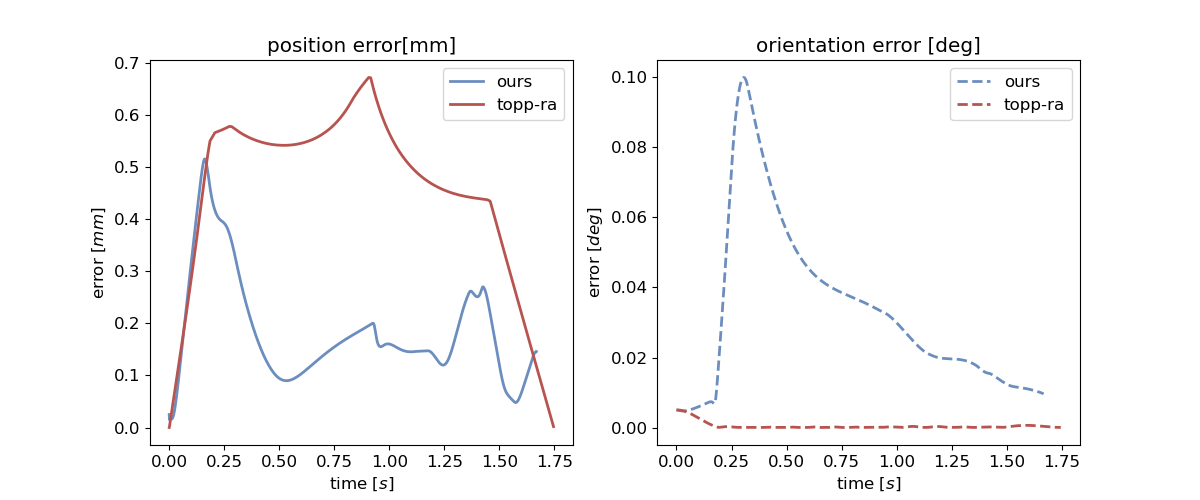

In [13]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=[12, 5])
ax[0].plot(data.t_ruckig, np.array(data.e_pos_list_ruckig)*1e3,'#6C8EBF',linewidth=linewidth, label="ours")
ax[0].plot(data_top.t_toppra,np.array(data_top.e_pos_list)*1e3,'#B85450',linewidth=linewidth, label="topp-ra")
ax[1].plot(data.t_ruckig,np.rad2deg(data.e_rot_list_ruckig),'--', color="#6C8EBF",linewidth=linewidth, label="ours")
ax[1].plot(data_top.t_toppra,np.rad2deg(data_top.e_rot_list),'r--',color="#B85450",linewidth=linewidth, label="topp-ra")


ax[0].set_title("position error[mm]")
ax[0].set_ylabel(r'error $[mm]$',color="black")
ax[1].set_ylabel(r'error $[deg]$',color="black")
ax[1].set_title("orientation error [deg]")
ax[0].set_xlabel(r'time $[s]$',color="black")
ax[1].set_xlabel(r'time $[s]$',color="black")
ax[0].legend()
ax[1].legend()

## Visualise the two robots executiong the trajectories

- ours - left
- toppra - right

In [14]:
panda_ours = panda_pyn.robot
panda_toppra = panda_pyn.robot

viewer = meshcat.Visualizer()
panda_ours.data = panda_ours.model.createData()
panda_toppra.data = panda_toppra.model.createData()

viz_l = MeshcatVisualizer(panda_ours.model, panda_ours.collision_model, panda_ours.visual_model)
viz_r = MeshcatVisualizer(panda_toppra.model, panda_toppra.collision_model, panda_toppra.visual_model)

# Start a new MeshCat server and client.
viz_l.initViewer(open=False, viewer=viewer)
# Load the robot in the viewer.
viz_l.loadViewerModel("topca")

viz_r.initViewer(open=False, viewer = viewer)
viz_r.loadViewerModel("toppra", color=[0.0,0.0,0.0,0.5])

T_shift = np.eye(4)
T_shift[1, 3] = 0.5  # 1 meter along y
# Apply to the root node of the second robot
viewer["toppra"].set_transform(T_shift)

panda_tip_pin = "panda_hand_tcp"

#viz.display_collisions = False
display(viz_l, panda_ours, panda_tip_pin, "end_effector_ruc", data.qr_list[0])
display(viz_r, panda_toppra, panda_tip_pin, "end_effector_toppra", data_top.qr_list[0])
viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


/home/gospar/miniconda3/envs/toppra_cart/lib/python3.12/site-packages/pinocchio/visualize/meshcat_visualizer.py:883: DeprecatedWarning: The 'color' argument is deprecated and will be removed in a future version of Pinocchio. Consider using 'collision_color' and 'visual_color' instead.
  warnings.warn(


### Launch the next code block to animate teh robots (LEFT: ours, RIGHT: toppra)

In [16]:
display_frame(viz_l, "start", X_init.np)
display_frame(viz_l, "end", X_final.np)

display_frame(viz_r, "start1", T_shift@X_init)
display_frame(viz_r, "end1", T_shift@X_final)

t0 = time.time()
t_max = max(data.t_ruckig[-1], data_top.t_toppra[-1])
while (time.time() - t0) < t_max:
    time.sleep(0.01)
    t_current = time.time() - t0
    try:
        
        ind_t = np.where(data_top.t_toppra > t_current)[0][0]
        #ind_t = np.where(ts_sample > t_current)[0][0]
    except:
        ind_t = len(data_top.t_toppra)-1
        #ind_t = len(ts_sample)-1
    try:    
        ind_r = np.where(data.t_ruckig > t_current)[0][0]
    except:
        ind_r = len(data.t_ruckig)-1
    display(viz_l, panda_ours, panda_tip_pin, "end_effector_ruc", data.qr_list[ind_r])
    display(viz_r, panda_toppra, panda_tip_pin, "end_effector_toppra", qs_sample[ind_t], T_shift)
